<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/%E6%A6%82%E6%97%A5%E3%83%AA%E3%82%BA%E3%83%A0_%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

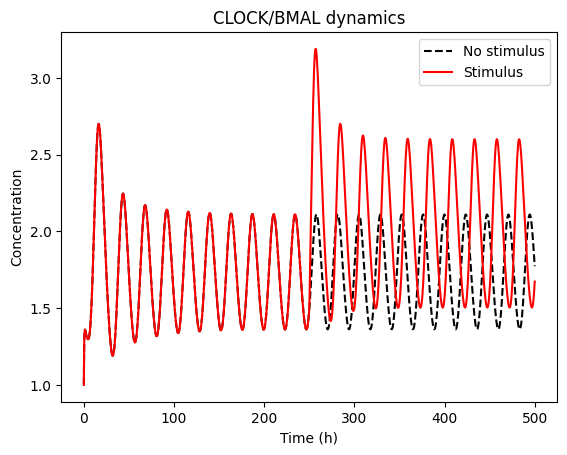

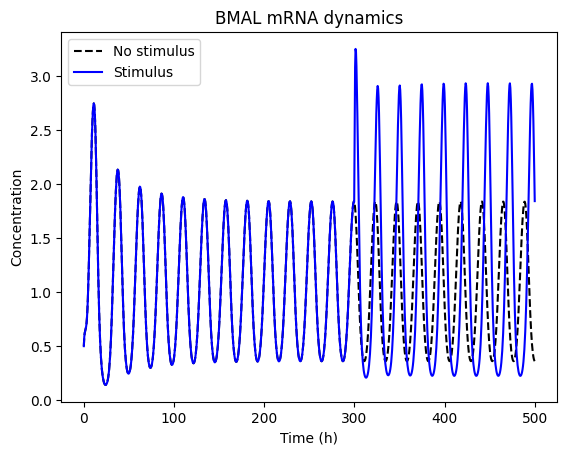

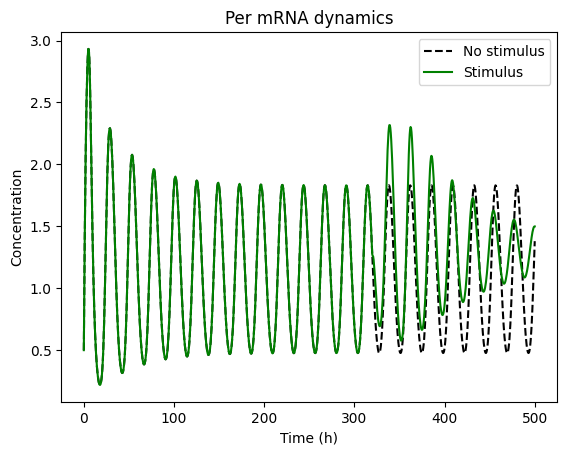

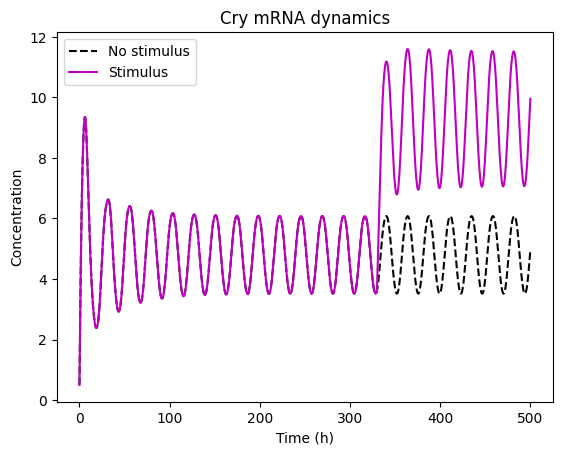

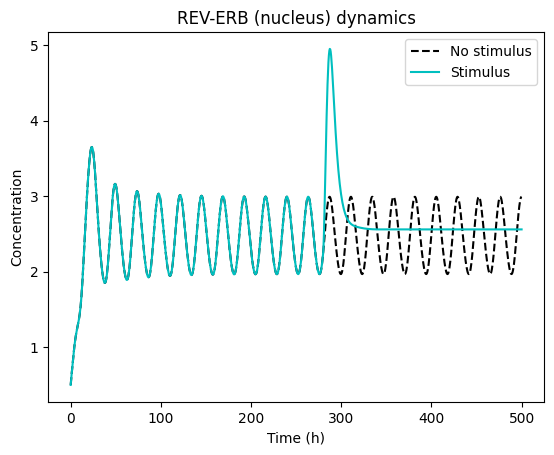

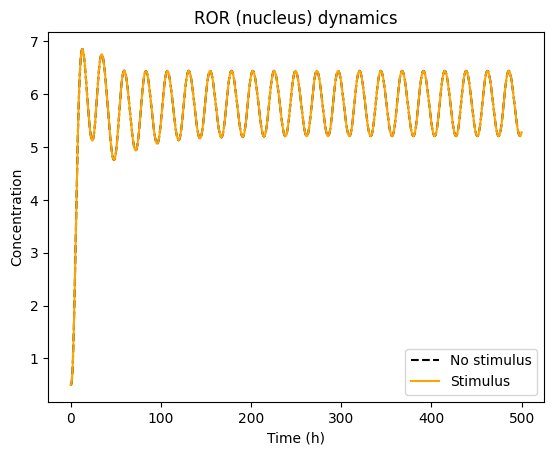

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import copy

def input_factor(t, t_switch, factor_before=1, factor_after=2):
    """
    時刻 t において、指定した t_switch を境に入力因子が変化するステップ関数
      - t_switch: 変化する時刻
      - factor_before: t < t_switch のときの値（通常状態）
      - factor_after:  t >= t_switch のときの値（刺激後）
    """
    return factor_before if t < t_switch else factor_after

def clock_ar2011(t, X, input_flags):
    """
    哺乳類概日リズムモデル (Clock_AR2011) の常微分方程式（Python版）
    各主要な生成項（転写・翻訳）に、個別の入力因子（刺激効果）を乗じます。
    input_flags で各項目に刺激を適用するかどうかを制御します。

    X : 19要素の状態ベクトル (0-indexed)
    input_flags : 各項目の刺激適用の真偽値が格納された辞書
    """
    x = X
    dX = np.zeros(19)

    # --- パラメータ設定 ---
    # 分解速度
    dx1, dx2, dx3 = 0.08, 0.06, 0.09
    dx5, dx6, dx7 = 0.17, 0.12, 0.15
    dy1, dy2, dy3, dy4, dy5 = 0.3, 0.2, 2, 0.2, 1.6
    dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8 = 0.23, 0.25, 0.6, 0.2, 0.2, 0.31, 0.3, 0.73

    # 複合体形成／解離の反応速度
    kfx1, kdx1 = 2.3, 0.01
    kfz4, kfz5 = 1, 1
    kdz5, kdz4 = 1, 1

    # リン酸化／脱リン酸化速度
    kfz2, kdfz3 = 2, 0.05

    # 転写速度
    V1max, V2max, V3max, V4max, V5max = 1, 2.92, 1.90, 10.90, 1
    kt1, kt2, kt3, kt4, kt5 = 3, 2.4, 2.07, 0.9, 8.35
    ki1, ki2, ki21, ki3, ki4, ki5 = 0.9, 0.7, 5.2, 3.3, 0.4, 1.94

    # 翻訳速度
    kp1, kp2, kp3, kp4, kp5 = 0.4, 0.26, 0.37, 0.76, 1.21

    # 輸送速度（import/export）
    kiz4, kiz5, kiz6, kiz7, kiz8 = 0.2, 0.1, 0.5, 0.1, 0.1
    kex2, kex3 = 0.02, 0.01

    # 転写活性化の fold 因子、Hill係数等
    a, d_ = 12, 12
    g, h, i_ = 5, 5, 12
    b, c = 5, 7
    e, f, f1 = 6, 4, 1
    v, w = 6, 2
    p, q = 6, 3
    n, m = 2, 5
    a2, a3 = 1, 1

    # 核内 PER/CRY 複合体プール（x[17]：18番目, x[18]：19番目）
    PC = a2 * x[17] + a3 * x[18]

    # 定数項（恒常発現とする因子）
    Rev0, Ror0, Bmal0, Per0, Cry0 = 0, 0, 0, 0, 0
    sf = 1.07  # 約23.5時間周期にスケール

    # --- 各生成項の入力因子 ---
    # 各項目は、input_flags により刺激が適用される場合にのみステップ入力が有効となる
    u_clock     = input_factor(t, t_switch=250, factor_before=1, factor_after=2) if input_flags.get("clock", False) else 1
    u_rev_mrna  = input_factor(t, t_switch=260, factor_before=1, factor_after=2) if input_flags.get("rev_mrna", False) else 1
    u_ror_mrna  = input_factor(t, t_switch=270, factor_before=1, factor_after=2) if input_flags.get("ror_mrna", False) else 1
    u_rev_prot  = input_factor(t, t_switch=280, factor_before=1, factor_after=2) if input_flags.get("rev_prot", False) else 1
    u_ror_prot  = input_factor(t, t_switch=290, factor_before=1, factor_after=2) if input_flags.get("ror_prot", False) else 1
    u_bmal_mrna = input_factor(t, t_switch=300, factor_before=1, factor_after=2) if input_flags.get("bmal_mrna", False) else 1
    u_bmal_prot = input_factor(t, t_switch=310, factor_before=1, factor_after=2) if input_flags.get("bmal_prot", False) else 1
    u_per_mrna  = input_factor(t, t_switch=320, factor_before=1, factor_after=2) if input_flags.get("per_mrna", False) else 1
    u_cry_mrna  = input_factor(t, t_switch=330, factor_before=1, factor_after=2) if input_flags.get("cry_mrna", False) else 1
    u_cry_prot  = input_factor(t, t_switch=340, factor_before=1, factor_after=2) if input_flags.get("cry_prot", False) else 1
    u_per_prot  = input_factor(t, t_switch=350, factor_before=1, factor_after=2) if input_flags.get("per_prot", False) else 1

    # --- ODEs ---
    dX[0]  = sf * ( u_clock * (kfx1 * x[9]) - kdx1 * x[0] - dx1 * x[0] )
    dX[1]  = sf * ( u_rev_mrna * (V3max * (1 + g * ((x[0]/kt3)**v)) / (1 + ((PC/ki3)**w)*((x[0]/kt3)**v) + (x[0]/kt3)**v)) - dy3 * x[1] )
    dX[2]  = sf * ( u_ror_mrna * (V4max * (1 + h * ((x[0]/kt4)**p)) / (1 + ((PC/ki4)**q)*((x[0]/kt4)**p) + (x[0]/kt4)**p)) - dy4 * x[2] )
    dX[3]  = sf * ( u_rev_prot * (kp3 * (x[1] + Rev0)) - kiz6 * x[3] - dz6 * x[3] )
    dX[4]  = sf * ( u_ror_prot * (kp4 * (x[2] + Ror0)) - kiz7 * x[4] - dz7 * x[4] )
    dX[5]  = sf * ( kiz6 * x[3] - dx5 * x[5] )
    dX[6]  = sf * ( kiz7 * x[4] - dx6 * x[6] )
    dX[7]  = sf * ( u_bmal_mrna * (V5max * (1 + i_ * ((x[6]/kt5)**n)) / (1 + (x[5]/ki5)**m + (x[6]/kt5)**n)) - dy5 * x[7] )
    dX[8]  = sf * ( u_bmal_prot * (kp5 * (x[7] + Bmal0)) - kiz8 * x[8] - dz8 * x[8] )
    dX[9]  = sf * ( kiz8 * x[8] + kdx1 * x[0] - kfx1 * x[9] - dx7 * x[9] )
    dX[10] = sf * ( u_per_mrna * (V1max * (1 + a * ((x[0]/kt1)**b)) / (1 + ((PC/ki1)**c)*((x[0]/kt1)**b) + (x[0]/kt1)**b) ) - dy1 * x[10] )
    dX[11] = sf * ( u_cry_mrna * (V2max * (1 + d_ * ((x[0]/kt2)**e)) / (1 + ((PC/ki2)**f)*((x[0]/kt2)**e) + (x[0]/kt2)**e) * (1/(1 + (x[5]/ki21)**f1)) ) - dy2 * x[11] )
    dX[12] = sf * ( u_cry_prot * (kp2 * (x[11] + Cry0) + kdz4 * x[15] + kdz5 * x[16]) - kfz5 * x[12] * x[13] - kfz4 * x[12] * x[14] - dz1 * x[12] )
    dX[13] = sf * ( u_per_prot * (kp1 * (x[10] + Per0) + kdz5 * x[16] + kdfz3 * x[14]) - kfz5 * x[13] * x[12] - kfz2 * x[13] - dz2 * x[13] )
    dX[14] = sf * ( kfz2 * x[13] + kdz4 * x[15] - kdfz3 * x[14] - kfz4 * x[14] * x[12] - dz3 * x[14] )
    dX[15] = sf * ( kfz4 * x[12] * x[14] + kex2 * x[17] - kiz4 * x[15] - kdz4 * x[15] - dz4 * x[15] )
    dX[16] = sf * ( kfz5 * x[12] * x[13] + kex3 * x[18] - kiz5 * x[16] - kdz5 * x[16] - dz5 * x[16] )
    dX[17] = sf * ( kiz4 * x[15] - kex2 * x[17] - dx2 * x[17] )
    dX[18] = sf * ( kiz5 * x[16] - kex3 * x[18] - dx3 * x[18] )

    return dX

# ------------------------
# 共通シミュレーション設定
# ------------------------

t_start = 0
t_end = 500
t_eval = np.linspace(t_start, t_end, 1000)
X0 = np.full(19, 0.5)
X0[0] = 1  # 初期条件：CLOCK/BMAL

# control_flags：すべての刺激がオフ（刺激なし状態）
control_flags = {
    "clock": False,
    "rev_mrna": False,
    "ror_mrna": False,
    "rev_prot": False,
    "ror_prot": False,
    "bmal_mrna": False,
    "bmal_prot": False,
    "per_mrna": False,
    "cry_mrna": False,
    "cry_prot": False,
    "per_prot": False
}

def run_simulation(flags):
    return solve_ivp(clock_ar2011, (t_start, t_end), X0, t_eval=t_eval, args=(flags,), method='RK45')

# ------------------------
# 各遺伝子について、刺激なし状態と刺激あり状態のシミュレーション結果を重ねてプロット
# ------------------------

# (1) CLOCK/BMAL (x[0])
flags_clock = copy.deepcopy(control_flags)
flags_clock["clock"] = True
sol_control = run_simulation(control_flags)
sol_stim    = run_simulation(flags_clock)
plt.figure()
plt.plot(sol_control.t, sol_control.y[0, :], 'k--', linewidth=1.5, label='No stimulus')
plt.plot(sol_stim.t, sol_stim.y[0, :], 'r', linewidth=1.5, label='Stimulus')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('CLOCK/BMAL dynamics')
plt.legend()

# (2) BMAL mRNA (x[7])
flags_bmal_mrna = copy.deepcopy(control_flags)
flags_bmal_mrna["bmal_mrna"] = True
sol_control = run_simulation(control_flags)
sol_stim    = run_simulation(flags_bmal_mrna)
plt.figure()
plt.plot(sol_control.t, sol_control.y[7, :], 'k--', linewidth=1.5, label='No stimulus')
plt.plot(sol_stim.t, sol_stim.y[7, :], 'b', linewidth=1.5, label='Stimulus')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('BMAL mRNA dynamics')
plt.legend()

# (3) Per mRNA (x[10])
flags_per_mrna = copy.deepcopy(control_flags)
flags_per_mrna["per_mrna"] = True
sol_control = run_simulation(control_flags)
sol_stim    = run_simulation(flags_per_mrna)
plt.figure()
plt.plot(sol_control.t, sol_control.y[10, :], 'k--', linewidth=1.5, label='No stimulus')
plt.plot(sol_stim.t, sol_stim.y[10, :], 'g', linewidth=1.5, label='Stimulus')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Per mRNA dynamics')
plt.legend()

# (4) Cry mRNA (x[11])
flags_cry_mrna = copy.deepcopy(control_flags)
flags_cry_mrna["cry_mrna"] = True
sol_control = run_simulation(control_flags)
sol_stim    = run_simulation(flags_cry_mrna)
plt.figure()
plt.plot(sol_control.t, sol_control.y[11, :], 'k--', linewidth=1.5, label='No stimulus')
plt.plot(sol_stim.t, sol_stim.y[11, :], 'm', linewidth=1.5, label='Stimulus')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Cry mRNA dynamics')
plt.legend()

# (5) REV-ERB (nucleus) (x[5])
flags_rev = copy.deepcopy(control_flags)
flags_rev["rev_prot"] = True
sol_control = run_simulation(control_flags)
sol_stim    = run_simulation(flags_rev)
plt.figure()
plt.plot(sol_control.t, sol_control.y[5, :], 'k--', linewidth=1.5, label='No stimulus')
plt.plot(sol_stim.t, sol_stim.y[5, :], 'c', linewidth=1.5, label='Stimulus')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('REV-ERB (nucleus) dynamics')
plt.legend()

# (6) ROR (nucleus) (x[6])
flags_ror = copy.deepcopy(control_flags)
flags_ror["ror_prot"] = False
sol_control = run_simulation(control_flags)
sol_stim    = run_simulation(flags_ror)
plt.figure()
plt.plot(sol_control.t, sol_control.y[6, :], 'k--', linewidth=1.5, label='No stimulus')
plt.plot(sol_stim.t, sol_stim.y[6, :], 'orange', linewidth=1.5, label='Stimulus')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('ROR (nucleus) dynamics')
plt.legend()

plt.show()
